# PUFEM for the Helmholtz Equation
Let $\Omega=(0,1)^2$ be the unit square.  
We will solve the homogeneous Helmholtz equation with Robin boundary conditions, i.e.
\begin{equation*} \begin{aligned} -\Delta u - k^2 u  & = 0 \quad \text{in} \ \Omega, \\ -\frac{\partial u}{\partial n} &=\alpha(u-g_R) \quad \text{on} \ \partial\Omega. \end{aligned} \end{equation*}

First we generate a mesh.

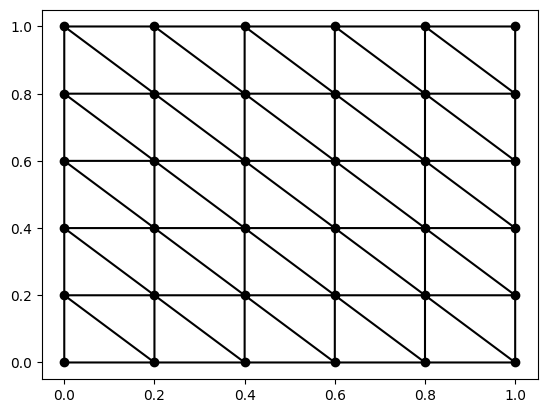

In [38]:
from import_hack import *
from methodsnm.mesh_2d import *
from methodsnm.visualize import *
N = 5
mesh = StructuredRectangleMesh(N,N)
h = 1.0/N
DrawMesh2D(mesh)

For the partition of unity finite element local approximation space we use a space of plane waves that solves the Helmholtz equation.  
Example of a plane wave:

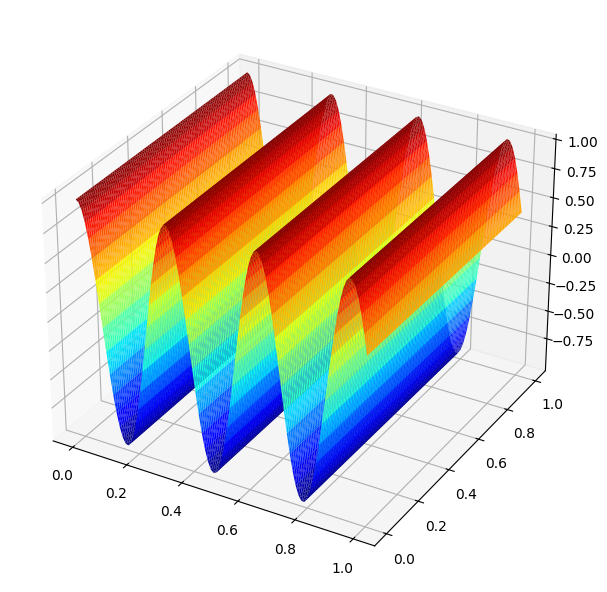

In [39]:
from numpy import exp,cos,sin,real,pi
m = StructuredRectangleMesh(10,10)
wavenumber_ = 20
theta_ = 2*pi
global_planewave =  GlobalFunction(lambda x: real(exp(1j*wavenumber_*((x[0])*cos(theta_)+(x[1])*sin(theta_)))), mesh = m)
DrawFunction2D(global_planewave, contour=False)

On the mesh we can define the partition of unity space:

In [40]:
from methodsnm.fes import *
from methodsnm.fe import PUFE
order = 2
wavenumber = 5
fes = PUFE_Space(mesh,order=order,wavenumber=wavenumber) 
#fes = P3_Triangle_Space(mesh)

We can now visulize the PUFEM basis functions 

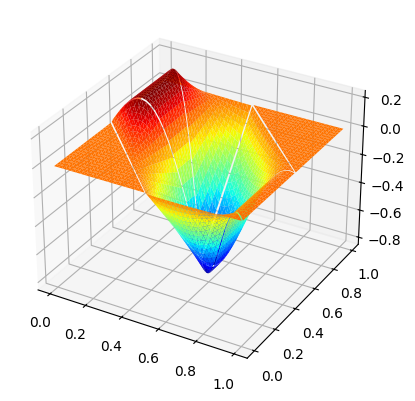

KeyboardInterrupt: 

In [41]:
from methodsnm.fes import PUFE_Space
from methodsnm.meshfct import FEFunction
m = StructuredRectangleMesh(2, 2)
fes_basis = PUFE_Space(m,order= order,wavenumber=wavenumber)
uh = FEFunction(fes_basis)
for i in range(4*(2*order+1),5*(2*order+1)):
    uh.vector[:] = 0
    uh.vector[i] = 1
    DrawFunction2D(uh, sampling=20, shrink_eps=0.025, figsize=(5,4), contour=False)

Deriving the weak formulation we obtain:
\begin{equation*}
\int\limits_{\Omega} \nabla u \nabla v dx - k^2 \int\limits_{\Omega} uv dx + \alpha \int\limits_{\partial \Omega}  u v ds
= \alpha \int\limits_{\partial \Omega} g_R v ds 
\end{equation*}
Here we chose the parameters
for $\partial \Omega = \Gamma_{north} \cup \Gamma_{south} \cup \Gamma_{west} \cup \Gamma_{east}$
\begin{equation*} \begin{aligned}
\alpha &= 1 \\
k &= 5\\
g_R&= -2(\sin(4y)+\cos(4y)) \quad \text{on} \ \Gamma_{west}\\ 
g_R&=(\sin(4y)+\cos(4y))(-2\sin(3)+4\cos(3)) \quad \text{on} \ \Gamma_{east}\\
g_R&= -3(\sin(3x)+\cos(3x)) \quad \text{on} \ \Gamma_{south}\\
g_R&= (\sin(3x)+\cos(3x))(-3\sin(4)+5\cos(4)) \quad \text{on} \ \Gamma_{north}\\
\end{aligned} \end{equation*}

In [ ]:
def coeff_g(x):
    if x[0]<=1e-10:
        return (sin(4*x[1])+cos(4*x[1]))*(-2)
    elif x[0]>=1-1e-10:
        return (sin(4*x[1])+cos(4*x[1]))*(-2*sin(3)+4*cos(3))
    elif x[1]<=1e-10:
        return (sin(3*x[0])+cos(3*x[0]))*(-3)
    elif x[1]>=1-1e-10:
        return (sin(3*x[0])+cos(3*x[0]))*(-3*sin(4)+5*cos(4))
    else:
        raise Exception('')
    
# another option for k=13 and alpha=1
def coeff_g2(x):
    if x[0]<=1e-10:
        return (sin(12*x[1])+cos(12*x[1]))*(-4)
    elif x[0]>=1-1e-10:
        return (sin(12*x[1])+cos(12*x[1]))*(-4*sin(5)+6*cos(5))
    elif x[1]<=1e-10:
        return (sin(5*x[0])+cos(5*x[0]))*(-11)
    elif x[1]>=1-1e-10:
        return (sin(5*x[0])+cos(5*x[0]))*(-11*sin(12)+13*cos(12))
    else:
        raise Exception('')

We can now assemble the stiffness matrix A and the solution vector b of the linear system $Ax=b$.

Since the shape functions are consisting of trigonometric functions using lower integration orders yields a bad approximation.

In [ ]:
from methodsnm.forms import *
from methodsnm.formint import *

intorder = 10 #choose intorder = None for intorder=fe_test.order+fe_trial.order
# doesn't work for mesh with N=1 and order=1

blf = BilinearForm(fes)
c = GlobalFunction(lambda x: 1, mesh = mesh)
r = GlobalFunction(lambda x: (-wavenumber)*wavenumber, mesh = mesh)
blf+=LaplaceIntegral(c,intorder=intorder)
blf+= MassIntegral(r,intorder=intorder)
blf+=BoundaryMassIntegral(c,intorder=intorder) #r=alpha
blf.assemble()

lf = LinearForm(fes)
f = GlobalFunction(lambda x: 0, mesh = mesh)
lf += SourceIntegral(f,intorder=intorder)
g=GlobalFunction(coeff_g,mesh=mesh)
lf+= NeumannBoundary(g,intorder=intorder) #g=alpha*g_R
lf.assemble()

The dimension of the kernel of the stiffness matrix is zero for the plane wave basis functions. Therefore, we dont have to regularize the stiffness matrix.

In [ ]:
from numpy.linalg import eig
mat = blf.matrix.toarray()
vals,vect = eig(mat)
total = 0
for i in vals:
    if i<1e-14 and i>-1e-14:
        total += 1
print('dimension of the kernel:',total)
#print('eigenvalues:',vals)

dimension of the kernel: 0


In [ ]:
if total>0:
    for i in range (fes.ndof):
        blf.matrix[i,i]+=1e-11

The number of non-zero entries of the stiffness matrix is:

In [ ]:
from numpy import count_nonzero
print(count_nonzero(mat))

5150


By solving the equation we get values for x.

In [ ]:
uh = FEFunction(fes)
from scipy.sparse.linalg import spsolve

uh.vector = spsolve(blf.matrix, lf.vector)
sol=blf.matrix*uh.vector

We can now visualize the approximate solution

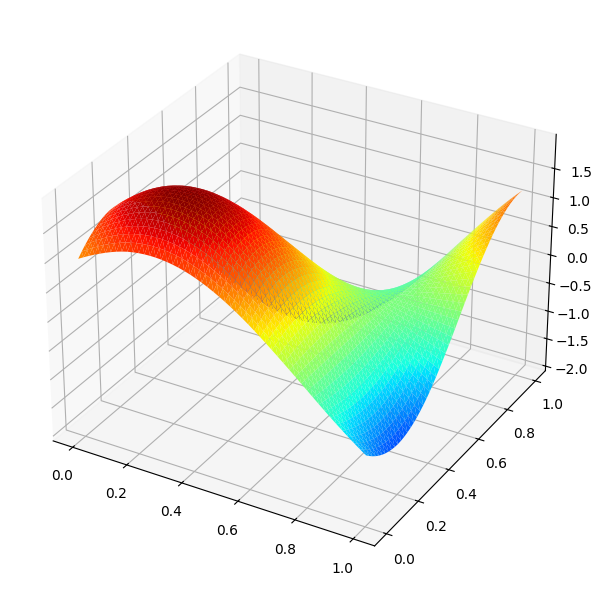

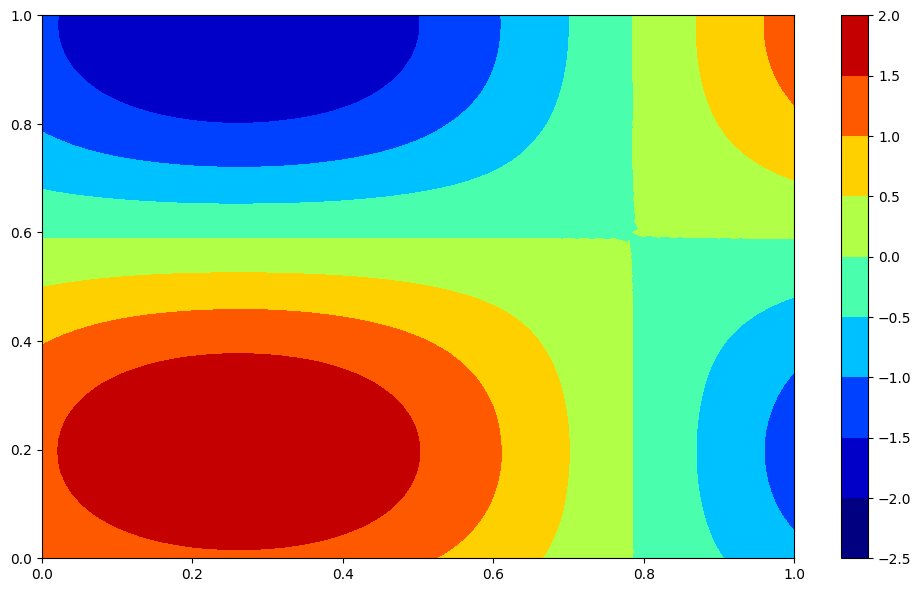

In [ ]:
DrawFunction2D(uh, contour=False)
DrawFunction2D(uh, contour=True)

The exact soltion is given by $$ u_{\text{ex}}=(\cos(3x)+\sin(3x))\cdot (\sin(4y)+\cos(4y))$$

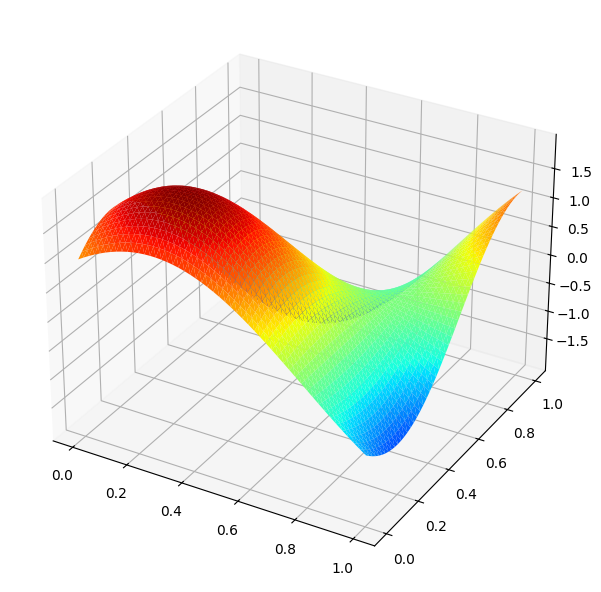

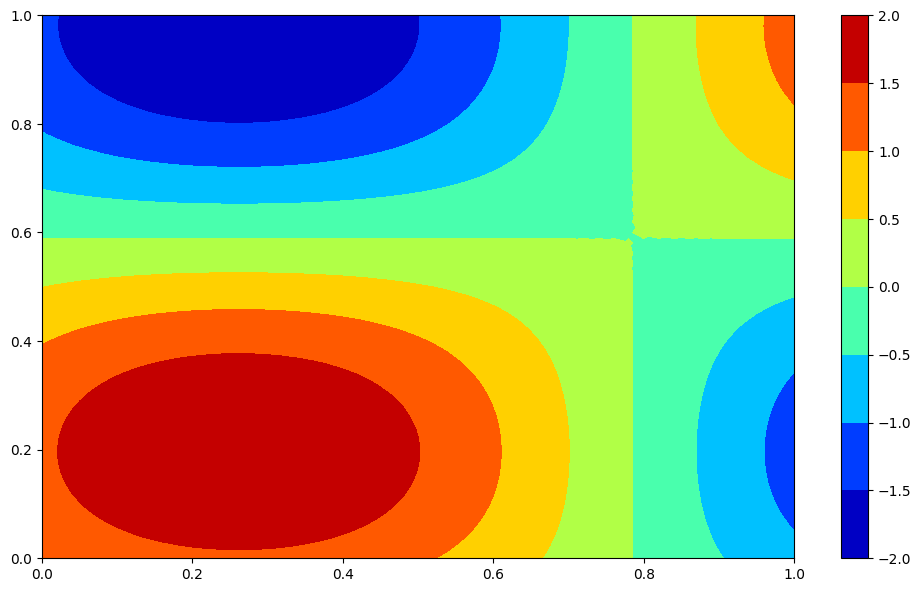

In [ ]:
from methodsnm.forms import compute_difference_L2
from numpy import exp,cos,sin
uex =  GlobalFunction(lambda x: (cos(3*x[0])+sin(3*x[0]))*(sin(4*x[1])+cos(4*x[1])), mesh = mesh)
uex2 =  GlobalFunction(lambda x: (cos(5*x[0])+sin(5*x[0]))*(sin(12*x[1])+cos(12*x[1])), mesh = mesh) #for coeff g2 and k=13
DrawFunction2D(uex, contour=False)
DrawFunction2D(uex, contour=True)

The L2 errror of the approximate solution is given by

In [ ]:
l2diff = compute_difference_L2(uh, uex, mesh, intorder = 6)
print("l2diff =", l2diff)

l2diff = 0.0008768682679071998
